# Using BERT models

This example shows how to use BERT models from the HuggingFace library. We will first take a look at the basic usage and how we apply the model, and then see how we can fine-tune the BERT model to classify documents.

To run this example, you need to make sure that the library `transformers` is installed. Please refer to [this page](https://huggingface.co/transformers/installation.html) for installation instructions, but in short you just need to install a package with `pip`. If you use Colab, the library is already installed.

**Note**: If you are using Colab, please check that the runtime type is set to GPU after copying this notebook.

### Using the BERT tokenizer

BERT has a built-in tokenizer. It uses WordPiece tokenization, which means that it will split rare words into pieces.

There are many models included in the `transformers` library, each one identified by a model name string. For a full list, see [here](https://huggingface.co/transformers/pretrained_models.html). We will mainly consider the *BERT* model, originally described in the [paper by Devlin et al. (2019)](https://aclanthology.org/N19-1423.pdf).

Each model in the `transformers` library comes with its own corresponding tokenizer: `BertTokenizer`, `DistilBertTokenizer`, `RobertaTokenizer`, etc. You need to make sure you use the right tokenizer for your model. Fortunately, in the latest version of the library, there is a utility called `AutoTokenizer` that will load the appropriate tokenizer for the model you have selected. Let's see how to use it.

In [1]:
from transformers import AutoTokenizer

In [2]:
model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_name)

To exemplify how the tokenizer works, let's see an example. Note that we have added the special dummy tokens BERT uses: `[CLS]` to mark the beginning of the text, `[SEP]` at the end, and some padding.

In [3]:
tokenizer.tokenize('[CLS] Rolf lives in Gothenburg. [SEP] [PAD] [PAD]')

['[CLS]', 'rolf', 'lives', 'in', 'gothenburg', '.', '[SEP]', '[PAD]', '[PAD]']

The following example shows how rare words are split into word pieces by the BERT tokenizer.

In [4]:
tokenizer.tokenize('Suzanna has broken the teapots.')

['su', '##zan', '##na', 'has', 'broken', 'the', 'tea', '##pot', '##s', '.']

We can also encode the tokens as integers. (Each BERT tokenizer comes with a vocabulary that carries out this mapping.) The encoding step automatically adds the `[CLS]` and `[SEP]` dummy tokens at the beginning and end, which is why we get 7 integers for 5 tokens.

In [5]:
tokenizer(['Rolf lives in Gothenburg.', 'Shorter example'],
         truncation=True, max_length=128,
         return_tensors='pt', padding=True)

{'input_ids': tensor([[  101, 23381,  3268,  1999, 22836,  1012,   102],
        [  101,  7820,  2742,   102,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 0]])}

### Trying out a BERT model from the Transformers library

For the tokenizer above, we used `AutoTokenizer` to load the right tokenizer, given a model name string. In a similar fashion, we use `AutoModel` here to load the right model. If you want to use another model, just change the name string in the hyperparameter settings below. (As mentioned above, see [this page](https://huggingface.co/transformers/pretrained_models.html) for a list of pre-trained models.) We'll typically get a warning message here, which we can ignore.

In [6]:
from transformers import AutoModel

example_bert_model = AutoModel.from_pretrained(model_name)

We create an example input. This batch consists of a single sentence. We use the tokenizer above to encode the words as integers. (As above, special dummy tokens have been added at the beginning and end.)

In [36]:
test_input = tokenizer(['The sun is shining and somthing .'], return_tensors='pt')
test_input.input_ids.shape

torch.Size([1, 11])

We can now apply the BERT model and get the output:

In [37]:
bert_output = example_bert_model(input_ids=test_input.input_ids,
                                 attention_mask=test_input.attention_mask,
                                 output_attentions=True, output_hidden_states=True)

In [38]:
bert_output.last_hidden_state.shape

torch.Size([1, 11, 768])

You can read about the output data structure here: https://huggingface.co/docs/transformers/main_classes/output

The parts of this data structure that are most interesting for us are:

- `last_hidden_state` (always returned)
- `hidden_states` (returned because we set `output_hidden_states` to `True`)
- `attentions` (returned because we set `attentions` to `True`)

Take a look at these objects and try to understand why they have the shapes they have. (Note: `hidden_states` and `attentions` are tuples.)

### Visualizing attention

The paper [*What does BERT look at? An Analysis of BERT's Attention*](https://aclanthology.org/W19-4828.pdf) by Clark et al (2019) describes an analysis of BERT's attention heads using visualization.

There is [an online tool](https://huggingface.co/exbert/?model=bert-base-uncased&modelKind=bidirectional) that can help you create visualizations similar to the paper.

You can also create visualizations in this notebook directly. The code below visualizes the attention scores using heatmaps.
**Note**: keep in mind that in the paper and in the visualization tool, the layers and attention heads are numbered starting from 1. So if you want to visualize the head 11-6 as in Figure 1 in the paper, you will have to write
```
bert_outputs.attentions[10][0, 5]
```

In [54]:
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
# plt.style.use('seaborn')
import numpy as np
import warnings

def plot_attention(input_ids, tokenizer, scores):
    scores = scores.detach().numpy()

    words = [tokenizer.decode(i) for i in input_ids]

    if tokenizer.pad_token in words:
        ix = words.index(tokenizer.pad_token)
        words = words[:ix]
        scores = scores[:ix, :ix]

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        fig, ax = plt.subplots()
        heatmap = ax.pcolor(scores, cmap='Blues_r')

        ax.set_xticklabels(words, minor=False, rotation='vertical')
        ax.set_yticklabels(words, minor=False)

        ax.xaxis.tick_top()
        ax.set_xticks(np.arange(scores.shape[1]) + 0.5, minor=False)
        ax.set_yticks(np.arange(scores.shape[0]) + 0.5, minor=False)
        ax.invert_yaxis()

        plt.colorbar(heatmap)

For instance, this code shows how head 1 in layer 3 attends to the next token as exemplified in Figure 1 in the paper.

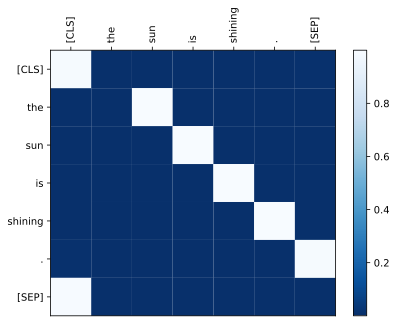

In [11]:
layer = 3
head = 1
sentence = 0
plot_attention(test_input.input_ids[sentence], tokenizer, bert_output.attentions[layer-1][sentence, head-1])

Try out the visualization tool or the heatmap visualization function in this notebook and try to see if you can see similar effects as described in the paper.

Do you think we can learn anything about a model by this kind of inspection? There have been debates in the research community, for instance in the following papers:
- Jain and Wallace (2019) [*Attention is not explanation*](https://aclanthology.org/N19-1357.pdf)
- Wiegreffe and Pinter (2019) [*Attention is not not explanation*](https://aclanthology.org/D19-1002.pdf)
- Bastings and Filippova (2020) [*The elephant in the interpretability room: Why use attention as explanation when we have saliency methods?*](https://aclanthology.org/2020.blackboxnlp-1.14.pdf)

### Masked language modeling

The BERT model was trained in a multitask fashion where one of the two training tasks is *masked language modeling*: for some tokens in the sentence, we substitute the dummy symbol `[MASK]` and then train the model to guess the missing words.

This masked language model can also be loaded via the library: we just need to use `AutoModelForMaskedLM` in this case. This loads the BERT model again, but also includes the "head" that predicts the missing tokens.

In [35]:
from transformers import AutoModelForMaskedLM

mlm = AutoModelForMaskedLM.from_pretrained(model_name)
mlm.config.hidden_size

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


768

The output of applying `mlm` is a data structure where the relevant part is a tensor called `logits`. What is the shape of this tensor?

Can you see what the BERT model predicts for the masked token in the sentence below?

**Hint:** In this case, the masked token is at position 5 (because a `[CLS]` token is added at position 0). In general, you can write something like the following to find the position of the masked token:
```
mask_position = list(masked_sentence.input_ids[0]).index(tokenizer.mask_token_id)
```

**Hint:** You may found it useful to apply either [`argmax`](https://pytorch.org/docs/stable/generated/torch.argmax.html) or [`topk`](https://pytorch.org/docs/stable/generated/torch.topk.html).

**Hint:** If you know the index `i` in the vocabulary for some token, you can find the corresponding word string by calling `tokenizer.decode(i)`.

In [13]:
masked_sentence = tokenizer('I went to the [MASK] to learn how to code.', return_tensors='pt')

In the paper by Petroni et al. (2019) called [*Language Models as Knowledge Bases?*](https://aclanthology.org/D19-1250.pdf), it is claimed that models such as BERT implicitly store quite a bit of encyclopedic knowledge that we can probe using the masked language model. Try to probe the model using sentences such as `[MASK] is the capital of Sweden.` and see if this idea seems reasonable. Can you think of any drawbacks of this approach?

Can you think of other experiments that would be interesting to carry out using the masked language model?

### Fine-tuning a BERT  model for document classification

For the classification task, we'll use our usual Amazon review benchmark. Some of the code here is identical to the previous notebook on document classifiction (with CBoW and BoW), with some small changes to adapt the code for the way that BERT deals with tokenization and vocabularies.

**Note**: the library includes ready-made solutions for document classification based on BERT (see [`BertForSequenceClassification`](https://huggingface.co/transformers/model_doc/bert.html#transformers.BertForSequenceClassification)), and it may seem a bit redundant that we design our own classifier on top of BERT. But the point here is that we'd like to show how to use BERT in a modular way as a general representation component, so that you can use it in other types of applications. You may also read about the [`Trainer`](https://huggingface.co/docs/transformers/main_classes/trainer) functionality as an alternative to the plain PyTorch solution we are using here to deal with preprocessing, training loop etc.

Now, let's use a BERT model as we previously used other representation components (e.g. CBoW, RNN). There's only one small issue to keep in mind here: BERT gives *word* representations, but how do we get *document* representations? The recommended solution with BERT is to extract the representation at the dummy `[CLS]` token at position 0.

<img src="http://www.cse.chalmers.se/~richajo/nlp2019/l5/bert_class.png" alt="BERT" style="width:30%;"/>

Now, please implement the code to build a document classifier on top of a BERT model. You will first need to declare the classification head (output unit) in `__init__`, and then implement the computation in `forward`.

In [66]:
from transformers import AutoModel
from torch import nn

class TextClassifierUsingBERT(nn.Module):

    def __init__(self, clf):
        super().__init__()

        print('Loading pre-trained model...')
        self.bert_model = AutoModel.from_pretrained(clf.params.bert_model_name)

        # Size of the pre-trained model's word representations.
        self.hidden_size = self.bert_model.config.hidden_size

        # Number of classes for the classification task.
        nbr_classes = clf.n_classes

        # Also don't forget to create a classification "head" (output unit).
        self.classification_head = nn.Linear(self.hidden_size, nbr_classes)

    def forward(self, Xbatch, Xmask):

        # Xbatch is the document tensor of shape (n_docs, max_length), where
        # n_docs is the number of documents in the batch, and max_length is
        # the maximal document length in the batch. Since we truncate the
        # documents to length 128 in this example, max_length will be 128
        # in most cases.
        # Xmask is the attention mask: it is 0 for the positions corresponding to
        # the padding tokens, and 1 elsewhere.

        # Your code here...
        # As usual, print the shapes of the tensors if you are confused!

        # When you have implemented this, the output shape should be (n_docs, nbr_classes)
        # as in our previous classifiers. This output contains the logits for the classes:
        # you do not have to apply a softmax.

        ber_out = self.bert_model(input_ids=Xbatch, attention_mask=Xmask)
        logits = self.classification_head(ber_out.last_hidden_state[:, 2, :])
        return logits
        


### Running the text classifier

Now, let's build the complete text classification model and train it on the dataset.

In [67]:
import pathlib
if not pathlib.Path('dredze_amazon_reviews.zip').exists():
   !wget http://www.cse.chalmers.se/~richajo/waspnlp2024/dredze_amazon_reviews.zip
   !unzip dredze_amazon_reviews.zip


In [68]:
import pandas as pd
amazon_corpus = pd.read_csv('dredze_amazon_reviews.tsv', sep='\t', header=None, names=['product', 'sentiment', 'text'])

**NOTE**: we use a lightly modified version of the classification code we used in previous lectures. The cell containing this code is available below and you need to exectute that cell before this one. (We put it below to improve readability of the notebook.)

In my experiments, I got accuracies around 0.88 when I truncate the documents to 128 tokens and use the distilled BERT model (a "compressed" BERT model that runs somewhat faster). You can get higher accuracies if you use longer documents or larger BERT models, but you should be careful in that case so that you don't run out of GPU memory.

This model is completely unregularized and the models seem to overfit quite quickly, with the accuracies sometimes peaking in the first epoch. Since each epoch takes about 2 minutes on my machine, so it's of course nice that we don't need to run it for many epochs.

In [69]:
class TextClassifierParametersBERT:
    val_size = 0.2
    device = 'cuda'
    n_epochs = 4
    batch_size = 32
    decay = 0
    max_len = 128
    bert_model_name = 'distilbert-base-uncased'

    # The BERT paper recommends learning rates 5e-5, 3e-5, or 2e-5
    learning_rate = 5e-5


torch.manual_seed(0)
clf = NNClassifier(TextClassifierParametersBERT(), TextClassifierUsingBERT)

clf.fit(list(amazon_corpus.text), list(amazon_corpus.sentiment))

Loading tokenizer...
Loading pre-trained model...
*** EPOCH 1 ***
.................................................. (50)
.................................................. (100)
.................................................. (150)
.................................................. (200)
.................................................. (250)
................................................
.................................................. (50)
.........................
Time: 32.6200; train loss: 0.3417; train acc: 0.8556; val loss: 0.2962; val acc: 0.8804
*** EPOCH 2 ***
.................................................. (50)
.................................................. (100)
.................................................. (150)
.................................................. (200)
.................................................. (250)
................................................
.................................................. (50)
.........................


If we want, we can run the classifier interactively on some test documents. How would you think a bag-of-words classifier would have handled these cases?

In [43]:
clf.predict(['A bad song!', 'A great song!', 'Not a bad song!', 'Not a great song!'])

array(['neg', 'pos', 'pos', 'neg'], dtype='<U3')

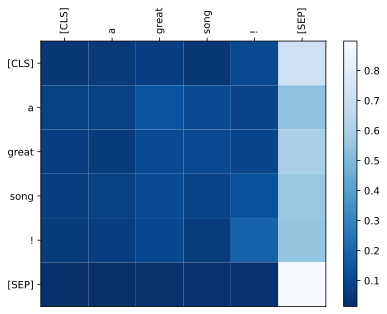

In [70]:
texts = ['A bad song!', 'A great song!', 'Not a bad song!', 'Not a great song!']
test_input = tokenizer(texts, return_tensors='pt', padding=True, truncation=True).to(clf.params.device)
bert_output = clf.model.bert_model(input_ids=test_input.input_ids, attention_mask=test_input.attention_mask, output_attentions=True, output_hidden_states=True)
layer = 6
head = 3
sentence = 1
plot_attention(test_input.input_ids[sentence], 
               tokenizer, bert_output.attentions[layer-1][sentence, head-1].cpu())

In [60]:
len(bert_output.attentions)

6

# Classification code

This is almost the same code as we used for previous classifiers. The *major* difference is that we do not use our own vocabulary, but instead rely on BERT's built-in tokenizer. Apart from this, there are only some small cosmetic changes.

Make sure you execute this cell before you run the classifier above.

In [18]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from transformers import AutoModel, AutoTokenizer

import numpy as np
import time
import sys
from collections import defaultdict, Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

class DocumentBatcher:
    """A collator that builds a batch from a number of documents."""

    def __init__(self, pad_id):
        self.pad_id = pad_id

    def make_batch_1(self, X):
        """Build a batch from a number of documents.
        Returns a tensor of shape [n_docs, max_doc_length]."""

        # How long is the longest document in this batch?
        max_len = max(len(x) for x in X)

        # Build the document tensor. We pad the shorter documents so that all documents
        # have the same length.
        Xpadded = torch.as_tensor([x + [self.pad_id]*(max_len-len(x)) for x in X])
        return Xpadded


    def make_batch_2(self, XY):
        """Build a batch from a number of documents and their labels.
        Returns two tensors X and Y, where X is the document tensor,
        of shape [n_docs, max_doc_length]

        and

        Y is the label tensor, of shape [n_docs].
        """

        # How long is the longest document in this batch?
        max_len = max(len(x) for x, _ in XY)

        # Build the document tensor. We pad the shorter documents so that all documents
        # have the same length.
        Xpadded = torch.as_tensor([x + [self.pad_id]*(max_len-len(x)) for x, _ in XY])

        # Build the label tensor.
        Y = torch.as_tensor([y for _, y in XY])

        return Xpadded, Y


    def __call__(self, instances):
        if isinstance(instances[0], tuple):
            return self.make_batch_2(instances)
        else:
            return self.make_batch_1(instances)


class NNClassifier:
    """A classifier based on a neural network."""

    def __init__(self, params, model_factory):
        self.params = params
        self.model_factory = model_factory
        print('Loading tokenizer...')
        self.tokenizer = AutoTokenizer.from_pretrained(params.bert_model_name)

    def preprocess(self, X, Y):

        Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size=self.params.val_size, random_state=0)

        self.lbl_enc = LabelEncoder()
        self.lbl_enc.fit(Ytrain)
        self.n_classes = len(self.lbl_enc.classes_)

        Xtrain_encoded = self.tokenizer(Xtrain, truncation=True, max_length=128).input_ids
        Xval_encoded = self.tokenizer(Xval, truncation=True, max_length=128).input_ids

        train_dataset = list(zip(Xtrain_encoded, self.lbl_enc.transform(Ytrain)))
        val_dataset = list(zip(Xval_encoded, self.lbl_enc.transform(Yval)))

        batcher = DocumentBatcher(self.tokenizer.pad_token_id)

        self.train_loader = DataLoader(train_dataset, self.params.batch_size, shuffle=True, collate_fn=batcher)
        self.val_loader = DataLoader(val_dataset, self.params.batch_size, shuffle=False, collate_fn=batcher)


    def fit(self, X, Y):
        """Train the model. We assume that a dataset and a model have already been provided."""
        par = self.params

        self.preprocess(X, Y)

        self.model = self.model_factory(self)
        self.model.to(par.device)

        self.loss_func = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=par.learning_rate, weight_decay=par.decay)

        self.history = defaultdict(list)

        for epoch in range(par.n_epochs):
            print(f'*** EPOCH {epoch+1} ***')

            t0 = time.time()

            self.model.train()
            train_loss, train_acc = self.epoch(self.train_loader, optimizer)

            self.model.eval()
            with torch.no_grad():
                val_loss, val_acc = self.epoch(self.val_loader)

            t1 = time.time()

            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['time'].append(t1-t0)

            print(f'Time: {t1-t0:.4f}; train loss: {train_loss:.4f}; train acc: {train_acc:.4f}; val loss: {val_loss:.4f}; val acc: {val_acc:.4f}')

    def epoch(self, batches, optimizer=None):
        """Runs the neural network for one epoch, using the given batches.
        If an optimizer is provided, this is training data and we will update the model
        after each batch. Otherwise, this is assumed to be validation data.

        Returns the loss and accuracy over the epoch."""
        n_correct = 0
        n_instances = 0
        total_loss = 0

        for step, (Xbatch, Ybatch) in enumerate(batches, 1):
            Xbatch = Xbatch.to(self.params.device)
            Xmask = (Xbatch != self.tokenizer.pad_token_id).long()
            Ybatch = Ybatch.to(self.params.device)

            scores = self.model(Xbatch, Xmask)

            loss = self.loss_func(scores, Ybatch)
            total_loss += loss.item()

            guesses = scores.argmax(dim=1)
            n_correct += (guesses == Ybatch).sum().item()
            n_instances += Ybatch.shape[0]

            if optimizer:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            print('.', end='')
            if step % 50 == 0:
              print(f' ({step})')

            sys.stdout.flush()

        print()

        return total_loss/len(batches), n_correct/n_instances


    def predict(self, X):
        """Run a trained classifier on a set of instances and return the predictions."""

        batcher = DocumentBatcher(self.tokenizer.pad_token_id)
        encoded = self.tokenizer(X).input_ids
        loader = DataLoader(encoded, self.params.batch_size, collate_fn=batcher)

        self.model.eval()
        outputs = []
        with torch.no_grad():
            for Xbatch in loader:
                Xbatch = Xbatch.to(self.params.device)
                Xmask = (Xbatch != self.tokenizer.pad_token_id).long()
                scores = self.model(Xbatch, Xmask)
                guesses = scores.argmax(dim=1)
                outputs.append(guesses.cpu().numpy())

        return self.lbl_enc.inverse_transform(np.hstack(outputs))
